Link Dataset: https://drive.google.com/drive/folders/15vHsWhVssm0NuoQBBrcV6EO5HH1ziJf5?usp=drive_link

In [ ]:
# ===========================================
# 0) Install dependensi
# ===========================================
!pip -q install gdown timm

import os, json, math, random, zipfile, csv, datetime
import numpy as np
import pandas as pd
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [ ]:
!fusermount -u /content/drive 2> /dev/null
!rm -rf /content/drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ===========================================
# 1) Path dataset dan label di MyDrive
# ===========================================
from google.colab import drive
drive.mount('/content/drive')

import os, csv, datetime, random
import numpy as np
import torch

BASE_DIR    = "/content/drive/MyDrive/tubes_dl"
DATASET_DIR = os.path.join(BASE_DIR, "dataset")
CSV_PATH    = os.path.join(BASE_DIR, "labels.csv")
SAVE_DIR    = BASE_DIR

os.makedirs(BASE_DIR, exist_ok=True)

RUN_ID  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = os.path.join(SAVE_DIR, f"run_{RUN_ID}")
os.makedirs(RUN_DIR, exist_ok=True)

METRIC_CSV = os.path.join(RUN_DIR, "metrics.csv")
with open(METRIC_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch","phase","train_acc","val_acc","val_f1",
                     "train_loss","lr_backbone","lr_head","margin"])

print("📂 RUN_DIR:", RUN_DIR)
print("Path dataset :", DATASET_DIR)
print("Path labels  :", CSV_PATH)

assert os.path.exists(DATASET_DIR), "Folder dataset tidak ditemukan!"
assert os.path.exists(CSV_PATH),    "File labels.csv tidak ditemukan!"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 RUN_DIR: /content/drive/MyDrive/tubes_dl/run_20251130_113638
Path dataset : /content/drive/MyDrive/tubes_dl/dataset
Path labels  : /content/drive/MyDrive/tubes_dl/labels.csv


In [ ]:
# ===========================================
# 2) Konfigurasi
# ===========================================
SAVE_DIR = "/content/drive/MyDrive/tubes_dl"  # hasil model
from google.colab import drive
drive.mount('/content/drive')

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
IMG_SIZE = 224; BATCH_SIZE = 16; EPOCHS = 100; PATIENCE = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


In [ ]:
# ===========================================
# 3) Load labels.csv & Split train/val (skip header baris pertama)
# ===========================================
import pandas as pd

df = pd.read_csv(
    CSV_PATH,
    header=0,                       # baris pertama = header -> tidak jadi data
    names=["filename", "label"],    # paksa nama kolom
    sep=r",|\t",                    # koma atau tab
    engine="python"
)

# bersihkan string
df["filename"] = df["filename"].astype(str).str.strip().str.replace(u"\ufeff", "", regex=False)
# Setelah df dibaca & dibersihkan:
df["label"] = (
    df["label"].astype(str)
      .str.strip()
      .str.replace(r"\s+", " ", regex=True)  # kolaps spasi berulang
      .str.casefold()                        # lower unicode-safe
)
df = df.dropna().reset_index(drop=True)

print(df.head())  # verifikasi: tidak ada literal 'filename' di data

# --- split: 1 gambar per kelas untuk validasi ---
SEED = 42
val_idx = []
for name, grp in df.groupby("label", sort=False):
    val_idx.extend(grp.sample(n=1, random_state=SEED).index.tolist())
val_df   = df.loc[val_idx].reset_index(drop=True)
train_df = df.drop(index=val_idx).reset_index(drop=True)

# mapping kelas
classes = sorted(df["label"].unique().tolist())
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in enumerate(classes)}

print(f"Kelas: {len(classes)} | Train: {len(train_df)} | Val: {len(val_df)}")

                      filename                  label
0  Fajrul Ramadhana Aqsa_1.jpg  fajrul ramadhana aqsa
1  Fajrul Ramadhana Aqsa_2.jpg  fajrul ramadhana aqsa
2  Fajrul Ramadhana Aqsa_3.jpg  fajrul ramadhana aqsa
3  Fajrul Ramadhana Aqsa_4.jpg  fajrul ramadhana aqsa
4         Freddy Harahap_1.jpg         freddy harahap
Kelas: 70 | Train: 208 | Val: 70


In [ ]:
# ===========================================
# 4) Dataset & Augmentasi — versi “diperbanyak + dihalusin”
#     + WeightedRandomSampler
# ===========================================
import os
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from collections import Counter

IMG_SIZE = 224

# Augmentasi: tetap kaya, tapi warna & geometrinya sedikit dihalusin
train_tfms = T.Compose([
    # crop dengan variasi tapi tidak terlalu ekstrim
    T.RandomResizedCrop(
        IMG_SIZE,
        scale=(0.85, 1.00),   # sebelumnya 0.80 → dinaikin dikit, biar muka nggak terlalu kepotong
        ratio=(0.90, 1.10)
    ),

    T.RandomHorizontalFlip(p=0.5),

    # warna: masih cukup kuat, tapi hue & saturation diturunin
    T.RandomApply([
        T.ColorJitter(
            brightness=0.20,   # tadinya 0.25
            contrast=0.20,
            saturation=0.20,
            hue=0.03           # tadinya 0.05
        )
    ], p=0.7),

    # grayscale kecil boleh, tapi jangan kegedean
    T.RandomGrayscale(p=0.05),   # tadinya 0.08

    # affine: rotasi/geser/zoom sedikit lebih kalem
    T.RandomAffine(
        degrees=8,               # tadinya 10
        translate=(0.04, 0.04),
        scale=(0.92, 1.08),      # range sedikit disempitkan
        shear=4
    ),

    # perspektif kecil-kecilan buat variasi (opsional, tapi berguna)
    T.RandomApply([
        T.RandomPerspective(distortion_scale=0.15, p=1.0)
    ], p=0.3),

    # blur ringan (tetap)
    T.RandomApply([
        T.GaussianBlur(kernel_size=3)
    ], p=0.25),                 # sedikit dikurangin dari 0.3

    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),

    # random erasing: tetap cukup sering, tapi area sedikit dipersempit
    T.RandomErasing(
        p=0.30,                  # tadinya 0.35
        scale=(0.02, 0.15),      # tadinya 0.02–0.18
        ratio=(0.3, 3.3),
        value=0
    ),
])

val_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])

POSSIBLE_EXTS = [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"]

class FaceDataset(Dataset):
    def __init__(self, df, root, tfm):
        self.df, self.root, self.tfm = df.reset_index(drop=True), root, tfm
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        fn  = self.df.iloc[i]["filename"]
        lbl = self.df.iloc[i]["label"]
        fp  = os.path.join(self.root, fn)

        if not os.path.exists(fp):
            base, ext = os.path.splitext(fp)
            ext_candidates = [ext] if ext else POSSIBLE_EXTS
            found = False
            for e in ext_candidates:
                pe = base + e
                if os.path.exists(pe):
                    fp = pe
                    found = True
                    break
            if not found:
                raise FileNotFoundError(f"File '{fn}' tidak ditemukan di {self.root}")

        img = Image.open(fp).convert("RGB")
        return self.tfm(img), class_to_idx[lbl]

# dataset
train_set = FaceDataset(train_df, DATASET_DIR, train_tfms)
val_set   = FaceDataset(val_df,   DATASET_DIR, val_tfms)

# class-balance weights
counts  = Counter([class_to_idx[l] for l in train_df["label"]])
weights = [1.0 / max(counts[class_to_idx[l]], 1) for l in train_df["label"]]

# faktor “perbanyak” per epoch:
# sebelumnya 4 → kita naikin jadi 6 biar model lihat lebih banyak variasi augment
EPOCH_SAMPLES_FACTOR = 9
num_samples = len(weights) * EPOCH_SAMPLES_FACTOR

sampler = WeightedRandomSampler(
    weights,
    num_samples=num_samples,
    replacement=True
)

BATCH_SIZE = 24  # kalau GPU kuat boleh 32
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)
val_loader   = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"✅ Augmentasi++ + WeightedRandomSampler | "
      f"train={len(train_set)} | val={len(val_set)} | classes={len(classes)} | "
      f"samples/epoch≈{num_samples}")


✅ Augmentasi++ + WeightedRandomSampler | train=208 | val=70 | classes=70 | samples/epoch≈1872


In [ ]:
# ===========================================
# 5) ResNet-50 (pretrained) + ArcFace
# ===========================================
import math, torch, torch.nn as nn, torch.nn.functional as F
import torchvision
from torchvision.models import resnet50, ResNet50_Weights

# ---- Embedding ResNet-50 ----
class ResNet50Embedding(nn.Module):
    def __init__(self, embed_dim=512, p_drop=0.5):
        super().__init__()
        # pretrained ImageNet (bukan zero-shot, tapi kita finetune)
        m = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        in_feats = m.fc.in_features
        m.fc = nn.Identity()
        self.backbone = m
        self.bn   = nn.BatchNorm1d(in_feats)
        self.drop = nn.Dropout(p_drop)
        self.fc   = nn.Linear(in_feats, embed_dim)
        nn.init.normal_(self.fc.weight, std=0.01)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        f = self.backbone(x)   # [B, 2048]
        f = self.bn(f)
        f = self.drop(f)
        return self.fc(f)      # [B, 512]

model = ResNet50Embedding(512, p_drop=0.5).to(DEVICE)

# ---- ArcFace head ----
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.20):
        """
        s: scale (biasanya 30–64)
        m: margin awal (nanti bisa dinaikkan di train loop sampai ~0.5)
        """
        super().__init__()
        self.s  = float(s)
        self.m  = float(m)
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        # cache konstanta utk margin
        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)
        self.th    = math.cos(math.pi - self.m)
        self.mm    = math.sin(math.pi - self.m) * self.m

    def update_margin(self, m: float):
        """optional: panggil ini di train loop kalau mau margin schedule"""
        self.m = float(m)
        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)
        self.th    = math.cos(math.pi - self.m)
        self.mm    = math.sin(math.pi - self.m) * self.m

    def forward(self, x, labels):
        # x: [B, D], labels: [B]
        x = F.normalize(x)
        W = F.normalize(self.weight)
        cos = F.linear(x, W)
        sin = torch.sqrt(torch.clamp(1.0 - cos * cos, min=1e-7))
        phi = cos * self.cos_m - sin * self.sin_m
        phi = torch.where(cos > self.th, phi, cos - self.mm)

        one_hot = torch.zeros_like(cos)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        logits = (one_hot * phi + (1.0 - one_hot) * cos) * self.s
        return logits

arc = ArcMarginProduct(512, len(classes), s=64.0, m=0.20).to(DEVICE)

# sedikit label smoothing supaya stabil di few-shot
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# ---- Optimizer dengan LR berbeda ----
backbone_lr = 1e-4   # kecil, supaya pretrain tidak rusak
head_lr     = 5e-4   # lebih besar utk BN+FC+ArcFace
wd          = 1e-4

opt = optim.AdamW([
    {"params": model.backbone.parameters(), "lr": backbone_lr, "weight_decay": wd},
    {"params": model.bn.parameters(),       "lr": backbone_lr, "weight_decay": wd},
    {"params": model.fc.parameters(),       "lr": head_lr,     "weight_decay": wd},
    {"params": arc.parameters(),            "lr": head_lr,     "weight_decay": wd},
])

# ---- Scheduler: warmup singkat + cosine ----
warmup_epochs = 3
sched_warmup  = optim.lr_scheduler.LinearLR(opt, start_factor=0.1, total_iters=warmup_epochs)
sched_main    = optim.lr_scheduler.CosineAnnealingLR(
    opt, T_max=max(EPOCHS - warmup_epochs, 1)
)

def step_scheduler(e):
    if e <= warmup_epochs:
        sched_warmup.step()
    else:
        if e == warmup_epochs + 1:
            sched_main.last_epoch = -1
        sched_main.step()

# ---- EMA utk backbone (stabilkan val) ----
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {n: p.detach().clone()
                       for n, p in model.named_parameters() if p.requires_grad}

    @torch.no_grad()
    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)

    @torch.no_grad()
    def apply_to(self, model):
        self.backup = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.backup[n] = p.detach().clone()
                p.data.copy_(self.shadow[n])

    @torch.no_grad()
    def restore(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                p.data.copy_(self.backup[n])

ema    = EMA(model, decay=0.999)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))


/tmp/ipython-input-1894230814.py:133: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))


In [ ]:
# === SANITY CHECK ===
from collections import Counter, defaultdict
import numpy as np
import torch.nn.functional as F

print("Classes total:", len(classes))
print("Top 10 kelas terbanyak (train):")
print(Counter(train_df["label"]).most_common(10))

# 1) Cek kelas tanpa sample di train atau val
train_counts = Counter(train_df["label"])
val_counts   = Counter(val_df["label"])
missing_train = [c for c in classes if train_counts[c]==0]
missing_val   = [c for c in classes if val_counts[c]==0]
print("Kelas tanpa TRAIN sample:", len(missing_train), missing_train[:5])
print("Kelas tanpa VAL sample  :", len(missing_val),   missing_val[:5])
assert len(missing_train)==0, "Ada kelas yang TIDAK punya sample di train!"
assert len(missing_val)==0,   "Ada kelas yang TIDAK punya sample di val!"

# 2) Apakah label “pecah” karena spasi/kapital?
u_train = set(train_df["label"].unique()); u_val = set(val_df["label"].unique())
diff = (u_train | u_val) - (u_train & u_val)
print("Label beda antara train/val:", len(diff))
if len(diff)>0: print(list(diff)[:10])

# 3) Prototype eval cepat (tanpa ArcFace) — harusnya > chance-level
model.eval()
with torch.no_grad():
    # centroid per kelas dari TRAIN
    feats = defaultdict(list)
    for x,y in train_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        e = model(x)
        e = F.normalize(e)
        for ei, yi in zip(e, y):
            feats[int(yi)].append(ei.detach().cpu().numpy())
    protos = []
    for k in range(len(classes)):
        if len(feats[k])==0:
            protos.append(np.zeros((e.size(1),), dtype=np.float32))
        else:
            p = np.stack(feats[k],0).mean(0)
            p = p/ (np.linalg.norm(p)+1e-8)
            protos.append(p)
    protos = torch.tensor(np.stack(protos,0), device=DEVICE, dtype=torch.float32)

    # evaluasi di VAL
    y_true, y_pred = [], []
    for x,y in val_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        e = model(x); e = F.normalize(e)
        sim = e @ protos.T
        pred = sim.argmax(1)
        y_true += y.cpu().tolist(); y_pred += pred.cpu().tolist()

from sklearn.metrics import accuracy_score, f1_score
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="macro", zero_division=0)
print(f"[Prototype Eval] Acc={acc:.3f} | F1={f1:.3f} | chance≈{1/len(classes):.3f}")
pred_dist = Counter(y_pred)
print("Distribusi prediksi (top-10):", pred_dist.most_common(10))


Classes total: 70
Top 10 kelas terbanyak (train):
[('fajrul ramadhana aqsa', 3), ('freddy harahap', 3), ('joshia fernandes sectio purba', 3), ('dimas azi rajab aizar', 3), ('abraham ganda napitu', 3), ('aldi sanjaya', 3), ('bezalel samuel manik', 3), ('desty ananta purba', 3), ('festus mikhael', 3), ('boy sandro sigiro', 3)]
Kelas tanpa TRAIN sample: 0 []
Kelas tanpa VAL sample  : 0 []
Label beda antara train/val: 0
[Prototype Eval] Acc=0.614 | F1=0.550 | chance≈0.014
Distribusi prediksi (top-10): [(26, 5), (31, 3), (36, 3), (1, 3), (15, 3), (29, 2), (61, 2), (65, 2), (6, 2), (33, 2)]


In [ ]:
# ===========================================
# 6) Train Loop (VAL LOSS + Acc + Prec + Rec + F1)
# ===========================================
import torch.nn.functional as F
import math
import csv
import os

def eval_tta_with_loss_and_pr():
    """Evaluasi pakai EMA + TTA, hitung: ValLoss, Acc, F1, Precision, Recall."""
    model.eval(); arc.eval()
    y_true, y_pred = [], []
    val_loss_sum, total = 0.0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            # TTA embeddings
            e1 = model(x)
            e2 = model(torch.flip(x, dims=[3]))
            emb = (e1 + e2) / 2.0

            # cosine logits (dipakai untuk prediksi & val loss CE)
            cos_logits = F.linear(F.normalize(emb), F.normalize(arc.weight)) * 30.0

            # VAL LOSS pakai CE biasa
            loss = criterion(cos_logits, y)

            val_loss_sum += loss.item() * x.size(0)
            total        += x.size(0)

            pred = cos_logits.argmax(1)
            y_true += y.cpu().tolist()
            y_pred += pred.cpu().tolist()

    val_acc   = accuracy_score(y_true, y_pred)
    val_f1    = f1_score(y_true, y_pred, average="macro", zero_division=0)
    val_prec  = precision_score(y_true, y_pred, average="macro", zero_division=0)
    val_rec   = recall_score(y_true, y_pred, average="macro", zero_division=0)
    val_loss  = val_loss_sum / max(total, 1)

    return val_acc, val_f1, val_prec, val_rec, val_loss, y_true, y_pred


# --- Optional: tulis header CSV sebelum loop (sekali saja) ---
with open(METRIC_CSV, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow([
        "epoch", "phase",
        "train_acc", "val_acc", "val_f1", "val_prec", "val_rec",
        "train_loss", "val_loss",
        "lr_backbone", "lr_head", "margin",
    ])

best_f1, patience = -1.0, 0

for ep in range(1, EPOCHS + 1):

    # ====== Margin Schedule (Warmup → ARC, lebih agresif) ======
    if ep > warmup_epochs:
        m_min, m_max = 0.30, 0.55   # dinaikkan biar "gacor"
        prog = min(1.0, (ep - warmup_epochs) / 10.0)  # ramp 10 epoch
        new_m = float(m_min + (m_max - m_min) * prog)

        if hasattr(arc, "update_margin"):
            arc.update_margin(new_m)
        else:
            arc.m = new_m
            arc.cos_m = math.cos(new_m)
            arc.sin_m = math.sin(new_m)
            arc.th = math.cos(math.pi - new_m)
            arc.mm = math.sin(math.pi - new_m) * new_m

    # ====== Train ======
    model.train(); arc.train()
    total, correct, loss_sum = 0, 0, 0.0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()

        with torch.amp.autocast('cuda', enabled=(DEVICE == 'cuda')):
            emb = model(x)

            # WARMUP (tanpa margin)
            if ep <= warmup_epochs:
                cos_logits = F.linear(F.normalize(emb), F.normalize(arc.weight)) * 30.0
                loss = criterion(cos_logits, y)
                pred = cos_logits.argmax(1)

            # ARC PHASE (hybrid ArcFace + cosine CE)
            else:
                logits_arc = arc(emb, y)  # include margin + scale
                cos_logits = F.linear(F.normalize(emb), F.normalize(arc.weight)) * 30.0

                loss_arc = criterion(logits_arc, y)
                loss_ce  = criterion(cos_logits, y)
                loss     = 0.5 * loss_arc + 0.5 * loss_ce

                pred = cos_logits.argmax(1)  # TrainAcc pakai cosine

        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(list(model.parameters()) + list(arc.parameters()), max_norm=5.0)
        scaler.step(opt); scaler.update()
        ema.update(model)

        bs = x.size(0)
        loss_sum += loss.item() * bs
        total    += bs
        correct  += (pred == y).sum().item()

    train_acc  = correct / max(total, 1)
    train_loss = loss_sum / max(total, 1)

    # ====== VAL (EMA + TTA + metrics lengkap) ======
    ema.apply_to(model)
    val_acc, val_f1, val_prec, val_rec, val_loss, y_true, y_pred = eval_tta_with_loss_and_pr()
    ema.restore(model)

    # ====== Scheduler ======
    step_scheduler(ep)

    lr_backbone = opt.param_groups[0]["lr"]
    lr_head     = opt.param_groups[2]["lr"]

    phase     = "WARMUP" if ep <= warmup_epochs else "ARC"
    current_m = float(getattr(arc, "m", 0.0))

    print(
        f"[{ep:02d}] {phase} | "
        f"TrainAcc={train_acc:.3f} | "
        f"ValAcc={val_acc:.3f} | ValF1={val_f1:.3f} | "
        f"ValPrec={val_prec:.3f} | ValRec={val_rec:.3f} | "
        f"TrainLoss={train_loss:.3f} | ValLoss={val_loss:.3f} | "
        f"lr_b={lr_backbone:.1e} | lr_h={lr_head:.1e} | m={current_m:.3f}"
    )

    # ====== LOG KE CSV ======
    with open(METRIC_CSV, "a", newline="") as f:
        w = csv.writer(f)
        w.writerow([
            ep, phase,
            f"{train_acc:.6f}",
            f"{val_acc:.6f}",
            f"{val_f1:.6f}",
            f"{val_prec:.6f}",
            f"{val_rec:.6f}",
            f"{train_loss:.6f}",
            f"{val_loss:.6f}",
            f"{lr_backbone:.8f}",
            f"{lr_head:.8f}",
            f"{current_m:.6f}",
        ])

    # ====== BEST MODEL SAVE (menurut ValF1) ======
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience = 0

        save_path = os.path.join(SAVE_DIR, "resnet50_arcface_best_gacor.pth")
        torch.save({
            "model": model.state_dict(),
            "arc": arc.state_dict(),
            "class_to_idx": class_to_idx,
            "idx_to_class": idx_to_class,
            "img_size": IMG_SIZE
        }, save_path)

        # confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
        fig = plt.figure(figsize=(8,7))
        plt.imshow(cm)
        plt.title("Confusion Matrix (Best)")
        plt.colorbar()
        plt.xticks(range(len(classes)), classes, rotation=90, fontsize=6)
        plt.yticks(range(len(classes)), classes, fontsize=6)
        plt.tight_layout()
        fig.savefig(os.path.join(SAVE_DIR, "confmat_resnet50_arcface_best_gacor.png"))
        plt.close(fig)

        # classification report
        with open(os.path.join(SAVE_DIR, "clf_report_resnet50_arcface_best_gacor.txt"), "w") as f:
            f.write(classification_report(
                y_true, y_pred, target_names=classes,
                digits=4, zero_division=0
            ))

    else:
        patience += 1
        if patience >= PATIENCE:
            print("Early stopping.")
            break

print("Training selesai, best F1:", best_f1)
print("Log epoch tersimpan di:", METRIC_CSV)


[01] WARMUP | TrainAcc=0.092 | ValAcc=0.014 | ValF1=0.010 | ValPrec=0.007 | ValRec=0.014 | TrainLoss=4.208 | ValLoss=4.923 | lr_b=4.0e-05 | lr_h=2.0e-04 | m=0.200
[02] WARMUP | TrainAcc=0.627 | ValAcc=0.029 | ValF1=0.019 | ValPrec=0.017 | ValRec=0.029 | TrainLoss=1.810 | ValLoss=4.431 | lr_b=7.0e-05 | lr_h=3.5e-04 | m=0.200
[03] WARMUP | TrainAcc=0.910 | ValAcc=0.086 | ValF1=0.058 | ValPrec=0.049 | ValRec=0.086 | TrainLoss=0.819 | ValLoss=4.024 | lr_b=1.0e-04 | lr_h=5.0e-04 | m=0.200
[04] ARC | TrainAcc=0.966 | ValAcc=0.200 | ValF1=0.157 | ValPrec=0.142 | ValRec=0.200 | TrainLoss=3.678 | ValLoss=3.624 | lr_b=1.0e-04 | lr_h=5.0e-04 | m=0.325
[05] ARC | TrainAcc=0.997 | ValAcc=0.243 | ValF1=0.184 | ValPrec=0.167 | ValRec=0.243 | TrainLoss=1.838 | ValLoss=3.435 | lr_b=1.0e-04 | lr_h=5.0e-04 | m=0.350
[06] ARC | TrainAcc=0.995 | ValAcc=0.343 | ValF1=0.306 | ValPrec=0.293 | ValRec=0.343 | TrainLoss=1.658 | ValLoss=3.091 | lr_b=1.0e-04 | lr_h=5.0e-04 | m=0.375
[07] ARC | TrainAcc=0.998 | Val

In [ ]:
import pandas as pd

df = pd.read_csv(METRIC_CSV)
print(df.head())
print("\nKolom yang ada:", df.columns.tolist())


   epoch   phase  train_acc   val_acc    val_f1  val_prec   val_rec  \
0      1  WARMUP   0.092415  0.014286  0.009524  0.007143  0.014286   
1      2  WARMUP   0.627137  0.028571  0.019048  0.017143  0.028571   
2      3  WARMUP   0.910256  0.085714  0.058095  0.048810  0.085714   
3      4     ARC   0.966346  0.200000  0.156960  0.141667  0.200000   
4      5     ARC   0.997329  0.242857  0.183571  0.166723  0.242857   

   train_loss  val_loss  lr_backbone  lr_head  margin  
0    4.208382  4.923411      0.00004  0.00020   0.200  
1    1.809864  4.431455      0.00007  0.00035   0.200  
2    0.818591  4.023686      0.00010  0.00050   0.200  
3    3.677539  3.623574      0.00010  0.00050   0.325  
4    1.837946  3.435073      0.00010  0.00050   0.350  

Kolom yang ada: ['epoch', 'phase', 'train_acc', 'val_acc', 'val_f1', 'val_prec', 'val_rec', 'train_loss', 'val_loss', 'lr_backbone', 'lr_head', 'margin']


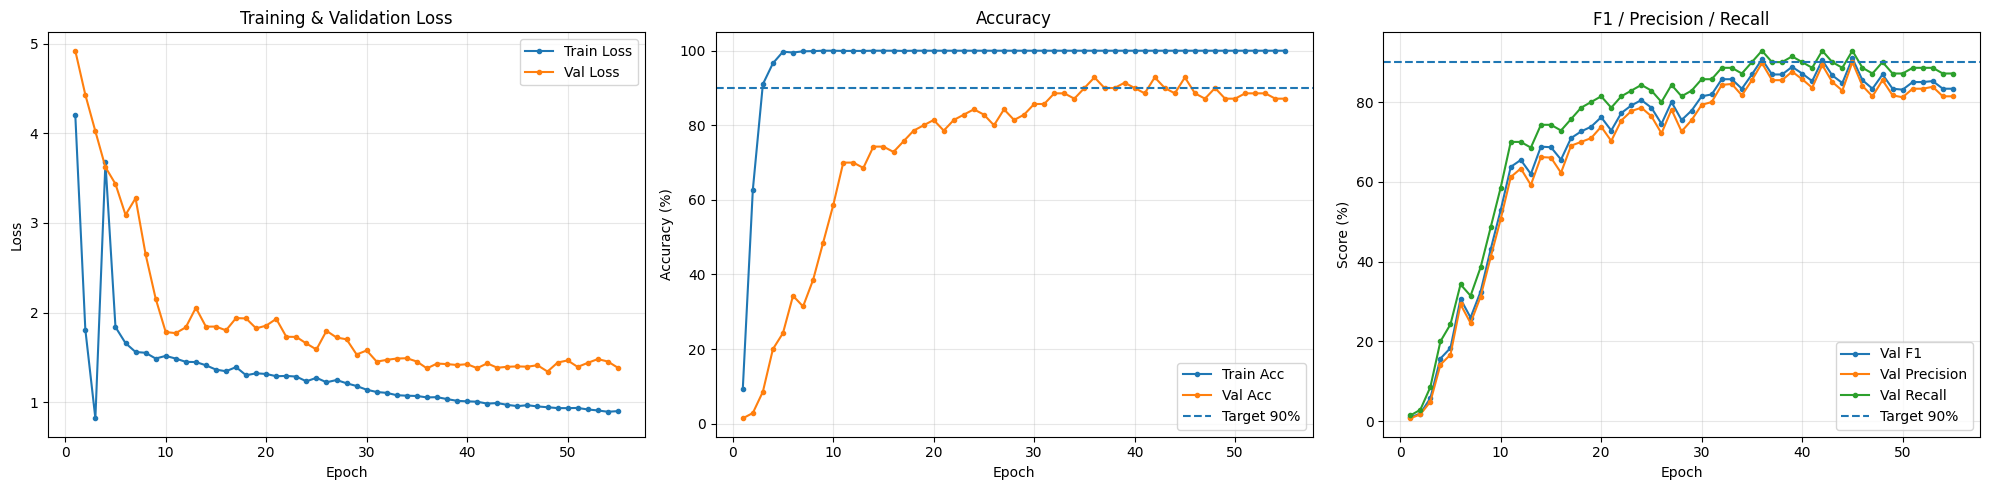

Plot history disimpan di: /content/drive/MyDrive/tubes_dl/training_history_metrics_full.png
Best ValAcc : 92.86%
Best ValF1  : 90.95%
Best ValPrec: 90.00%
Best ValRec : 92.86%


In [ ]:
# ===========================================
# 7) Plot Training History (Loss + Acc + F1/Prec/Rec)
# ===========================================
import pandas as pd
import matplotlib.pyplot as plt
import os

df = pd.read_csv(METRIC_CSV)

epochs     = df["epoch"]
train_loss = df["train_loss"].astype(float)
val_loss   = df["val_loss"].astype(float)

train_acc  = df["train_acc"].astype(float) * 100
val_acc    = df["val_acc"].astype(float) * 100
val_f1     = df["val_f1"].astype(float) * 100
val_prec   = df["val_prec"].astype(float) * 100
val_rec    = df["val_rec"].astype(float) * 100

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ---------- PANEL 1: LOSS ----------
axes[0].plot(epochs, train_loss, label="Train Loss", marker="o", markersize=3)
axes[0].plot(epochs, val_loss,   label="Val Loss",   marker="o", markersize=3)
axes[0].set_title("Training & Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# ---------- PANEL 2: ACCURACY ----------
axes[1].plot(epochs, train_acc, label="Train Acc", marker="o", markersize=3)
axes[1].plot(epochs, val_acc,   label="Val Acc",   marker="o", markersize=3)
axes[1].axhline(y=90, linestyle="--", label="Target 90%")

axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc="lower right")

# ---------- PANEL 3: F1 / PREC / REC ----------
axes[2].plot(epochs, val_f1,   label="Val F1",        marker="o", markersize=3)
axes[2].plot(epochs, val_prec, label="Val Precision", marker="o", markersize=3)
axes[2].plot(epochs, val_rec,  label="Val Recall",    marker="o", markersize=3)
axes[2].axhline(y=90, linestyle="--", label="Target 90%")

axes[2].set_title("F1 / Precision / Recall")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Score (%)")
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc="lower right")

plt.tight_layout()
save_path = os.path.join(SAVE_DIR, "training_history_metrics_full.png")
plt.savefig(save_path, dpi=150, bbox_inches="tight")
plt.show()

print("Plot history disimpan di:", save_path)
print(f"Best ValAcc : {val_acc.max():.2f}%")
print(f"Best ValF1  : {val_f1.max():.2f}%")
print(f"Best ValPrec: {val_prec.max():.2f}%")
print(f"Best ValRec : {val_rec.max():.2f}%")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === 1) Evaluasi model (TTA + EMA) ===
model.eval()
ema.apply_to(model)

# versi terbaru eval_tta_with_loss_and_pr()
val_acc, val_f1, val_prec, val_rec, val_loss, y_true, y_pred = eval_tta_with_loss_and_pr()

ema.restore(model)

# === 2) Confusion Matrix RAW ===
cm = confusion_matrix(
    y_true,
    y_pred,
    labels=list(range(len(classes)))
)

plt.figure(figsize=(32, 30))

sns.heatmap(
    cm,
    cmap="Blues",
    annot=False,
    fmt="d",
    xticklabels=classes,
    yticklabels=classes
)

plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.title(f"Confusion Matrix (RAW) | Acc={val_acc:.3f} | F1={val_f1:.3f}", fontsize=24)

plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)

plt.tight_layout()

# === 3) SAVE ===
CM_PATH = os.path.join(RUN_DIR, "confusion_matrix_raw.png")
plt.savefig(CM_PATH, dpi=300)
plt.close()

print("Confusion matrix RAW disimpan ke:", CM_PATH)


Confusion matrix RAW disimpan ke: /content/drive/MyDrive/tubes_dl/run_20251130_113638/confusion_matrix_raw.png


In [ ]:
import torch
import torch.nn.functional as F

def load_resnet50_arcface_from_ckpt(ckpt_path, device="cuda"):

    ckpt = torch.load(ckpt_path, map_location=device)

    class_to_idx = ckpt["class_to_idx"]
    idx_to_class = ckpt["idx_to_class"]
    num_classes  = len(class_to_idx)

    # --- MODEL & ARC ---
    model = ResNet50Embedding(embed_dim=512, p_drop=0.5)
    arc   = ArcMarginProduct(512, num_classes, s=30.0, m=0.50)
    # m = 0.50 → match final margin kamu
    # s = 30 → default ArcFace for inference (lebih stabil)

    model.load_state_dict(ckpt["model"])
    arc.load_state_dict(ckpt["arc"])

    model.to(device).eval()
    arc.to(device).eval()

    # --- NORMALISASI idx_to_class ---
    # 1) Jika LIST → buat mapping otomatis
    if isinstance(idx_to_class, list):
        idx_to_class_map = {i: v for i, v in enumerate(idx_to_class)}

    # 2) Jika DICT int → str
    elif all(isinstance(k, int) for k in idx_to_class.keys()):
        idx_to_class_map = idx_to_class

    # 3) Jika DICT str → int (seperti kasus kamu)
    elif all(isinstance(v, int) for v in idx_to_class.values()):
        idx_to_class_map = {v: k for k, v in idx_to_class.items()}

    else:
        raise ValueError("Format idx_to_class tidak dikenali:", idx_to_class)

    return model, arc, class_to_idx, idx_to_class_map


In [ ]:
# ========== RUN EVALUATION (sekali) ==========
model.eval()
ema.apply_to(model)
val_acc, val_f1, val_prec, val_rec, val_loss, y_true, y_pred = eval_tta_with_loss_and_pr()
ema.restore(model)

print(f"ValAcc={val_acc:.4f}, F1={val_f1:.4f}, Prec={val_prec:.4f}, Rec={val_rec:.4f}")


ValAcc=0.8714, F1=0.8333, Prec=0.8143, Rec=0.8714


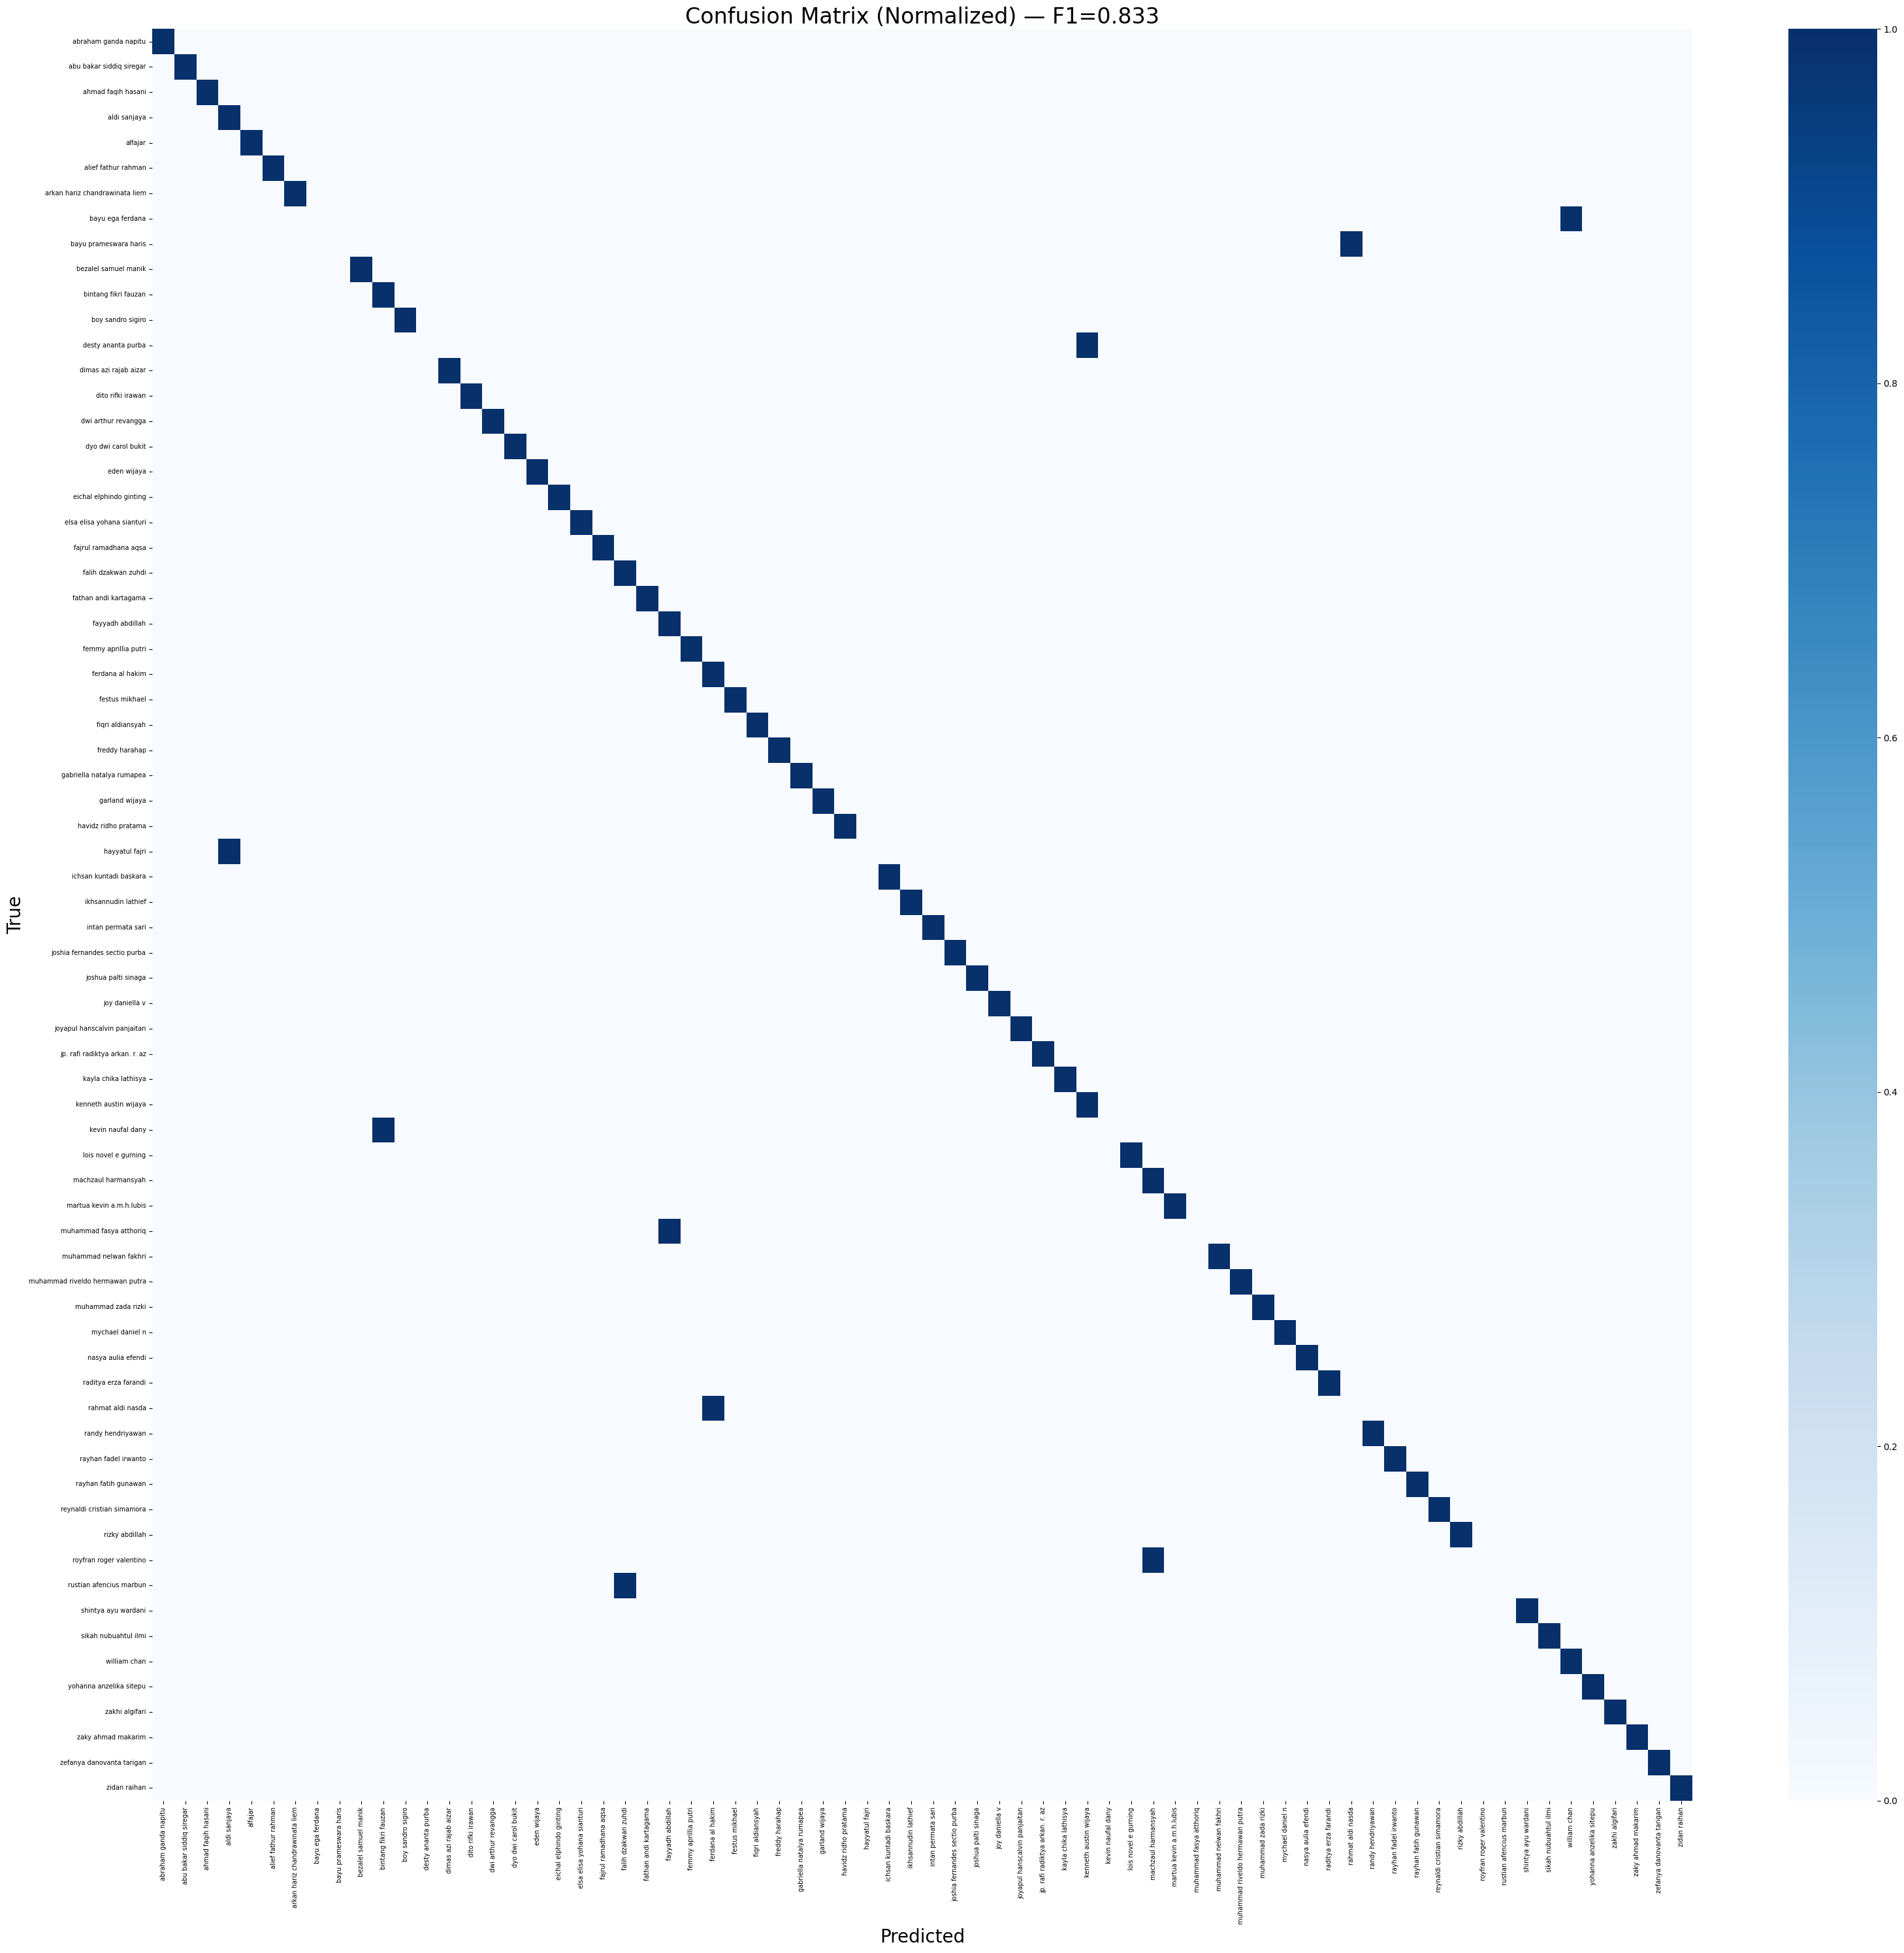

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(32, 30))

sns.heatmap(
    cm_norm,
    annot=False,    # kalau mau angka taro True
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
    vmin=0, vmax=1
)

plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.title(f"Confusion Matrix (Normalized) — F1={val_f1:.3f}", fontsize=24)

plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(RUN_DIR, "confmat_normalized.png"), dpi=300)


In [ ]:
errors = 1 - cm.diagonal() / cm.sum(axis=1)
order = np.argsort(errors)[::-1]

print("\n===== TOP 5 HARDEST CLASSES =====")
for i in order[:5]:
    print(f"{classes[i]}  — Error: {errors[i]:.3f}")

acc_per_class = cm.diagonal() / cm.sum(axis=1)
order = np.argsort(acc_per_class)[::-1]

print("\n===== TOP 5 EASIEST CLASSES =====")
for i in order[:5]:
    print(f"{classes[i]} — Accuracy: {acc_per_class[i]:.3f}")



===== TOP 5 HARDEST CLASSES =====
hayyatul fajri  — Error: 1.000
kevin naufal dany  — Error: 1.000
muhammad fasya atthoriq  — Error: 1.000
rahmat aldi nasda  — Error: 1.000
rustian afencius marbun  — Error: 1.000

===== TOP 5 EASIEST CLASSES =====
zidan raihan — Accuracy: 1.000
zefanya danovanta tarigan — Accuracy: 1.000
zaky ahmad makarim — Accuracy: 1.000
zakhi algifari — Accuracy: 1.000
yohanna anzelika sitepu — Accuracy: 1.000


In [ ]:
plt.figure(figsize=(32, 30))

sns.heatmap(
    cm_norm,
    cmap="Reds",
    annot=False,
    xticklabels=classes,
    yticklabels=classes,
)

plt.title("Prediction Difficulty Map", fontsize=24)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(RUN_DIR, "difficulty_map.png"), dpi=300)
plt.close()


In [ ]:
from tqdm import tqdm

def extract_embeddings():
    model.eval()
    ema.apply_to(model)
    embeds, labels = [], []

    with torch.no_grad():
        for x, y in tqdm(val_loader):
            x = x.to(DEVICE)
            emb = model(x).cpu().numpy()
            embeds.append(emb)
            labels.extend(y.numpy())

    ema.restore(model)
    return np.vstack(embeds), np.array(labels)

emb, lbl = extract_embeddings()


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
emb2d = tsne.fit_transform(emb)

plt.figure(figsize=(12, 12))
sns.scatterplot(x=emb2d[:,0], y=emb2d[:,1], hue=[classes[i] for i in lbl], s=10)
plt.legend(fontsize=6)
plt.title("t-SNE Embedding Space")
plt.tight_layout()
plt.savefig(os.path.join(RUN_DIR, "tsne_embeddings.png"), dpi=300)
plt.close()


In [ ]:
W = arc.weight.detach().cpu().numpy()
W_norm = W / np.linalg.norm(W, axis=1, keepdims=True)

dist = 1 - (W_norm @ W_norm.T)

plt.figure(figsize=(30, 28))
sns.heatmap(dist, cmap="viridis", xticklabels=classes, yticklabels=classes)
plt.title("Class Centroid Distance Map", fontsize=22)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(RUN_DIR, "class_distance_map.png"), dpi=300)
plt.close()


In [ ]:
CKPT_BEST = os.path.join(SAVE_DIR, "resnet50_arcface_best_gacor.pth")

model_best, arc_best, class_to_idx, idx_to_class_map = load_resnet50_arcface_from_ckpt(
    CKPT_BEST, device=DEVICE
)

model_best.eval()
arc_best.eval()

# versi tanpa EMA (karena ckpt sudah simpan EMA)
def eval_tta_noema(model_used, arc_used):
    y_true, y_pred = [], []
    val_loss_sum, total = 0.0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            e1 = model_used(x)
            e2 = model_used(torch.flip(x, dims=[3]))
            emb = (e1 + e2) / 2.0

            cos_logits = F.linear(F.normalize(emb), F.normalize(arc_used.weight)) * 30.0
            loss = criterion(cos_logits, y)

            val_loss_sum += loss.item() * x.size(0)
            total += x.size(0)

            pred = cos_logits.argmax(1)
            y_true += y.cpu().tolist()
            y_pred += pred.cpu().tolist()

    val_acc  = accuracy_score(y_true, y_pred)
    val_f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)
    val_prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    val_rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    val_loss = val_loss_sum / max(total, 1)

    return val_acc, val_f1, val_prec, val_rec, val_loss, y_true, y_pred

val_acc_b, val_f1_b, val_prec_b, val_rec_b, val_loss_b, *_ = eval_tta_noema(model_best, arc_best)
print(val_acc_b, val_f1_b, val_prec_b, val_rec_b)


0.8714285714285714 0.8333333333333333 0.8142857142857143 0.8714285714285714


In [ ]:
# ======================
# 1. LOAD CHECKPOINT
# ======================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CKPT_PATH = "/content/drive/MyDrive/tubes_dl/resnet50_arcface_best_gacor.pth"

model_test, arc_test, class_to_idx_test, idx_to_class_test = load_resnet50_arcface_from_ckpt(
    CKPT_PATH,
    device=DEVICE,
)

print("Loaded classes:", len(class_to_idx_test))
print("Sample mapping:", list(idx_to_class_test.items())[:5])

# pastikan ke device & eval
model_test.to(DEVICE).eval()
arc_test.to(DEVICE).eval()

Loaded classes: 70
Sample mapping: [(0, 'abraham ganda napitu'), (1, 'abu bakar siddiq siregar'), (2, 'ahmad faqih hasani'), (3, 'aldi sanjaya'), (4, 'alfajar')]


ArcMarginProduct()

In [ ]:
# ======================
# 2. TRANSFORM INFERENCE
# ======================
infer_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),        # sama seperti val_tfms
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])

In [ ]:
# ======================
# 3. FUNGSI PREDIKSI
# ======================
def predict_image(path, model, arc, idx_to_class, topk=5, device=DEVICE):
    img = Image.open(path).convert("RGB")
    inp = infer_tfms(img).unsqueeze(0).to(device)

    model.eval()
    arc.eval()

    with torch.no_grad(), torch.amp.autocast(
        device_type='cuda',
        enabled=(device.startswith("cuda"))
    ):
        emb = model(inp)
        # pakai cosine logits + scale 30.0 (sama seperti training)
        cos_logits = F.linear(F.normalize(emb), F.normalize(arc.weight)) * 30.0
        probs = F.softmax(cos_logits, dim=1)

    num_classes = len(idx_to_class)
    topk = min(topk, num_classes)

    topk_probs, topk_idx = probs.topk(topk, dim=1)

    results = []
    for p, idx in zip(topk_probs[0].cpu().tolist(), topk_idx[0].cpu().tolist()):
        label = idx_to_class.get(idx, f"<unk-{idx}>")
        results.append((label, float(p)))

    return img, results

Saving bintang.jpeg to bintang (1).jpeg
File: bintang (1).jpeg


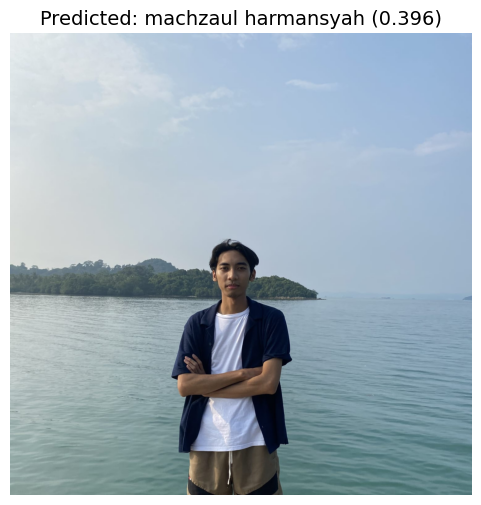


Top-5 Predictions:
  → machzaul harmansyah             prob≈ 0.396
  → jp. rafi radiktya arkan. r. az  prob≈ 0.314
  → fayyadh abdillah                prob≈ 0.081
  → kenneth austin wijaya           prob≈ 0.061
  → intan permata sari              prob≈ 0.028




In [ ]:
# ======================
# 4. UPLOAD & TEST GAMBAR
# ======================
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print("File:", fn)

    img, preds = predict_image(
        fn,
        model_test,
        arc_test,
        idx_to_class_test,
        topk=5,
        device=DEVICE,
    )

    # --- Tampilkan gambar ---
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")

    # --- Judul top-1 ---
    top1_name, top1_prob = preds[0]
    plt.title(f"Predicted: {top1_name} ({top1_prob:.3f})", fontsize=14)
    plt.show()

    # --- Print semua top-5 ---
    print("\nTop-5 Predictions:")
    for name, p in preds:
        print(f"  → {name:30s}  prob≈ {p:.3f}")
    print("\n" + "="*60 + "\n")